# Model database fetching and inference

## Load model & set up genome

In [1]:
# Set package settings
import matplotlib
import os

## Set the font type to ensure text is saved as whole words
matplotlib.rcParams["pdf.fonttype"] = 42  # Use TrueType fonts instead of Type 3 fonts
matplotlib.rcParams["ps.fonttype"] = 42  # For PostScript as well, if needed

## Set the base directory for data retrieval with crested.get_dataset()/get_model()
os.environ['CRESTED_DATA_DIR'] = '/staging/leuven/stg_00002/lcb/cblaauw/'

In [2]:
from pathlib import Path
import numpy as np
import keras
import crested
import matplotlib.pyplot as plt

2026-02-16 14:45:40.805578: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-16 14:45:51.380989: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-16 14:46:46.470798: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Set the genome
genome = crested.Genome("mm10/genome.fa", "mm10/genome.chrom.sizes")
crested.register_genome(genome)

2026-02-16T14:48:20.230621+0100 INFO Genome genome registered.


In [4]:
model_path, output_names_biccn = crested.get_model("DeepBICCN")
model_biccn = keras.models.load_model(model_path, compile=False)

2026-02-16 14:48:22.969805: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78751 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:26:00.0, compute capability: 9.0


## Region predictions and contribution scores

In [5]:
chrom, start, end = "chr3", 72535878, 72536378
midpoint = (start+end)//2
start_resized, end_resized = midpoint - 2114//2, midpoint + 2114//2
sequence = genome.fetch(chrom, start_resized, end_resized)

prediction = crested.tl.predict(sequence, model_biccn)

2026-02-16T14:48:25.812594+0100 INFO Lazily importing module crested.tl. This could take a second...


I0000 00:00:1771249769.485113 2303310 service.cc:145] XLA service 0x14ca28003fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771249769.500634 2303310 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2026-02-16 14:49:31.717288: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-16 14:49:34.033549: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


I0000 00:00:1771249779.091830 2303310 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2026-02-16T14:49:39.462694+0100 INFO Lazily importing module crested.pl. This could take a second...


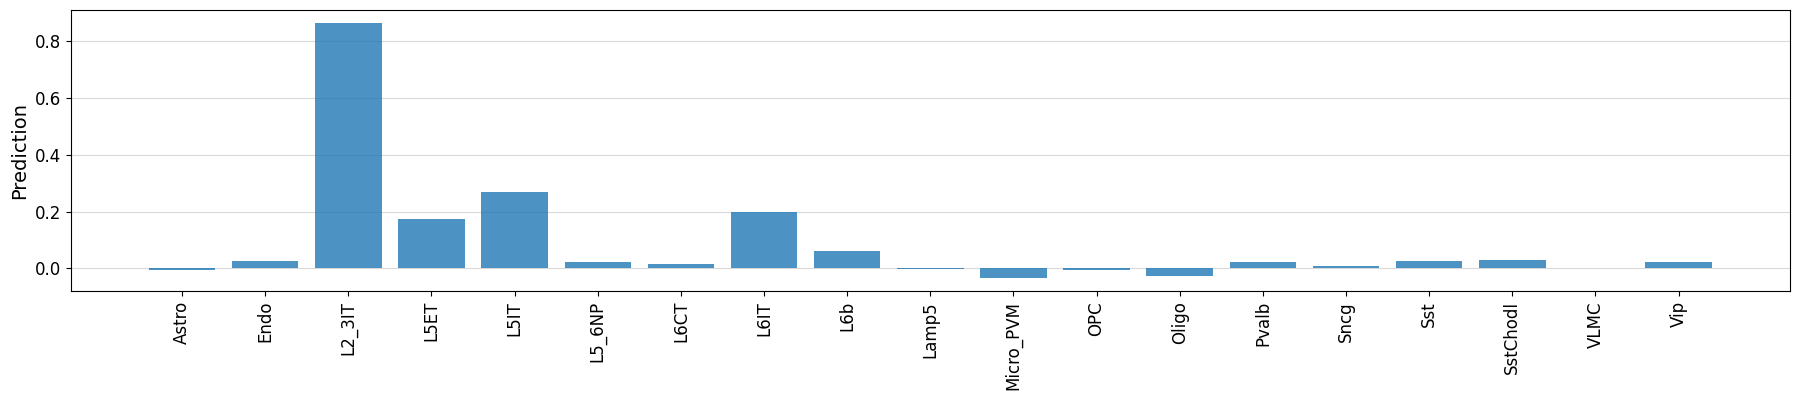

In [6]:
%matplotlib inline
crested.pl.region.bar(prediction, classes=output_names_biccn, xtick_rotation=90)

In [7]:
classes_of_interest = output_names_biccn[np.argmax(prediction)]
class_idx = np.argmax(prediction)

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,
    model=model_biccn,
    batch_size=32,
)

2026-02-16T14:49:45.921519+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:09<00:00,  9.12s/it]


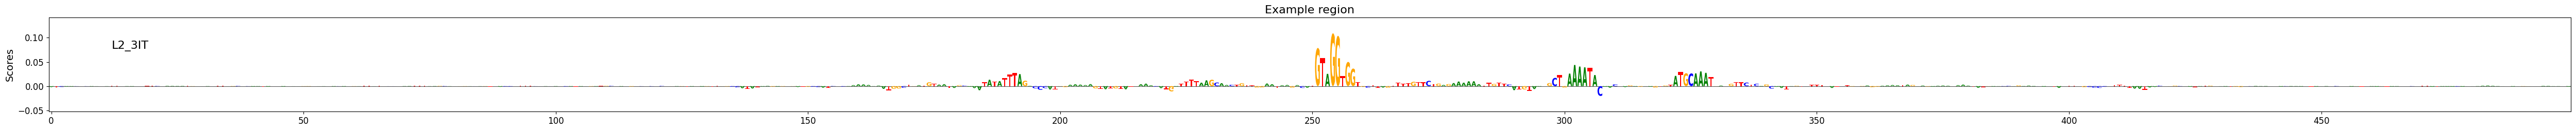

In [8]:
%matplotlib inline
crested.pl.explain.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Example region",
)  # zoom in on the center 500bp

### Same region with another model

In [9]:
model_path, output_names_dmb3 = crested.get_model("DeepMouseBrain3")
model_dmb3 = keras.models.load_model(model_path, compile=False)

100%|██████████████████████████████████████| 95.9M/95.9M [00:00<00:00, 203GB/s]
Untarring contents of '/staging/leuven/stg_00002/lcb/cblaauw/models/deepmousebrain3.tar.gz' to '/staging/leuven/stg_00002/lcb/cblaauw/models/deepmousebrain3.tar.gz.untar'


In [10]:
prediction = crested.tl.predict(sequence, model_dmb3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


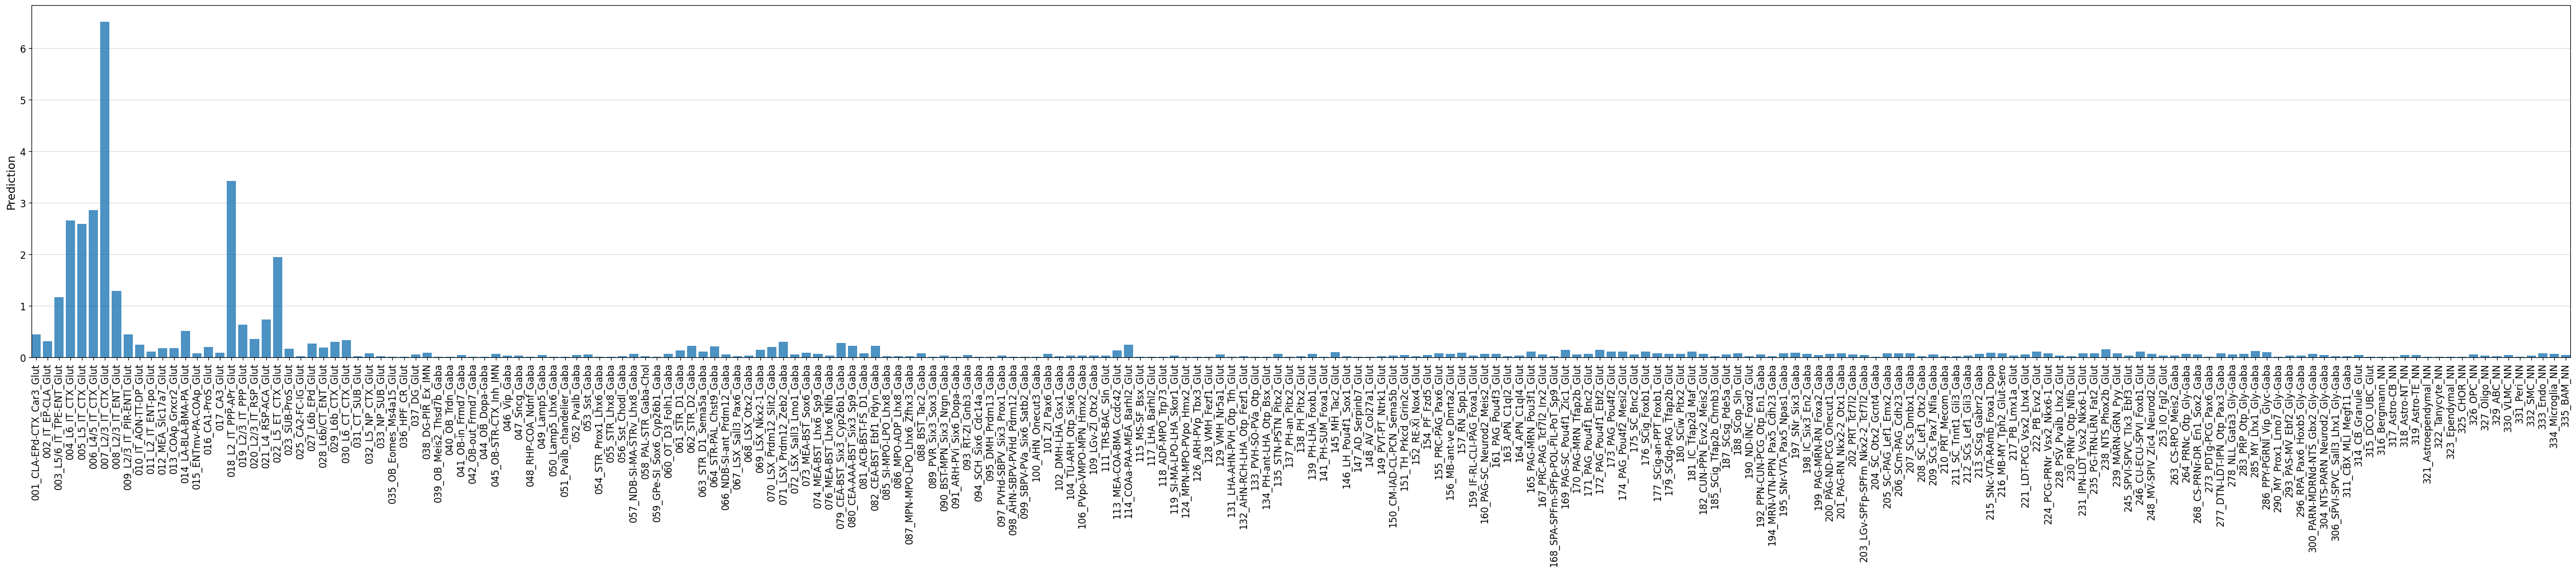

In [13]:
fig, ax = crested.pl.region.bar(prediction, classes=output_names_dmb3, xtick_rotation=90, width=45, height=10, show=False)
ax.margins(x=0)

In [14]:
classes_of_interest = output_names_dmb3[np.argmax(prediction)]
class_idx = np.argmax(prediction)

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,
    model=model_dmb3,
    batch_size=32,
)

2026-02-16T14:50:49.623296+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:05<00:00,  5.71s/it]


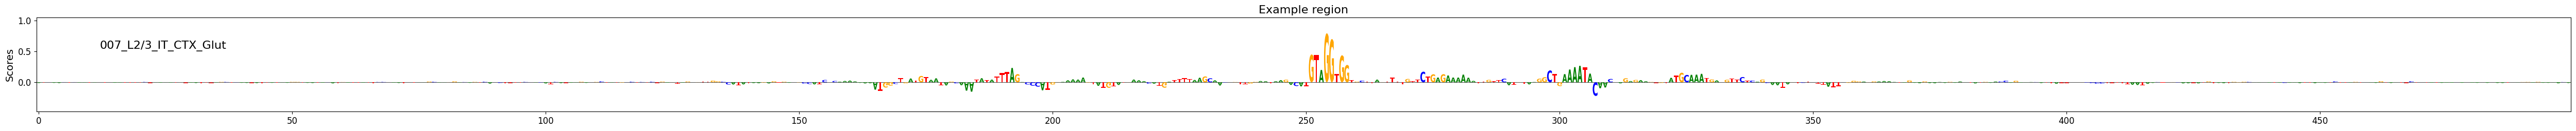

In [15]:
%matplotlib inline
crested.pl.explain.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Example region",
)

## Track predictions

In [16]:
model_path, output_names_bp = crested.get_model("borzoiprime_mouse_rep0")
model_bp = keras.models.load_model(model_path, compile=False)

100%|███████████████████████████████████████| 666M/666M [00:00<00:00, 1.69TB/s]
Untarring contents of '/staging/leuven/stg_00002/lcb/cblaauw/models/borzoiprime_mouse_rep0.tar.gz' to '/staging/leuven/stg_00002/lcb/cblaauw/models/borzoiprime_mouse_rep0.tar.gz.untar'


In [17]:
start_borzoi, end_borzoi = midpoint - 524288//2, midpoint + 524288//2
start_borzoi_output, end_borzoi_output = midpoint - 196608//2, midpoint + 196608//2
sequence_borzoi = genome.fetch(chrom, start_borzoi, end_borzoi)
prediction = crested.tl.predict(sequence_borzoi, model_bp)

I0000 00:00:1771249960.630870 2304380 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_49', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1771249960.727841 2304386 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_49', 64 bytes spill stores, 48 bytes spill loads

I0000 00:00:1771249960.994859 2304382 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_49', 36 bytes spill stores, 36 bytes spill loads

I0000 00:00:1771249961.471161 2304383 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1771249961.659246 2304382 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 16 bytes spill stores, 16 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


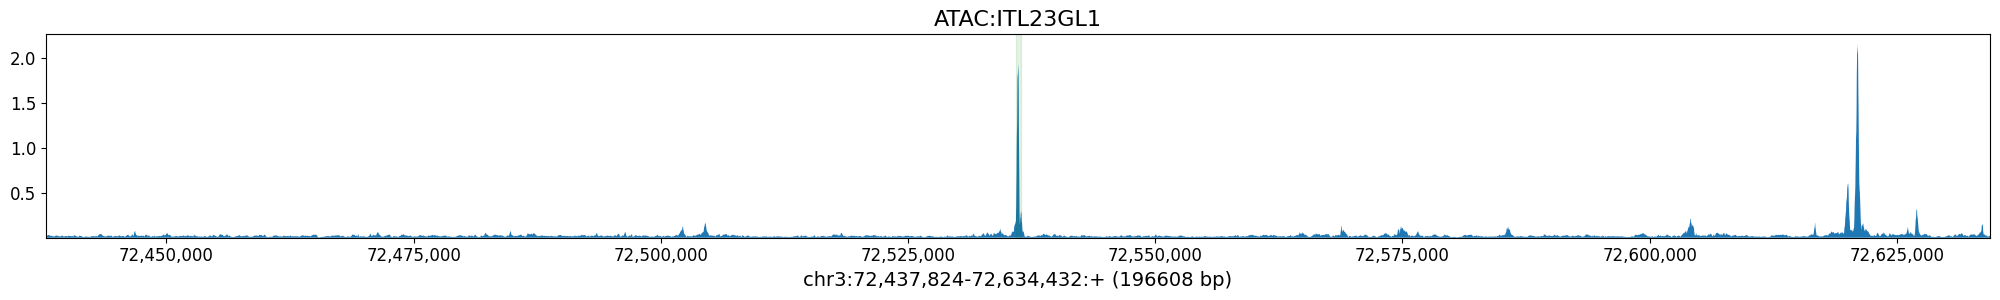

In [19]:
%matplotlib inline
class_idx = output_names_bp.index('ATAC:ITL23GL1') # Borzoi Prime Layer 2/3 neuron class

crested.pl.locus.track(
    prediction,
    class_idxs=class_idx,
    coordinates=(chrom, start_borzoi_output, end_borzoi_output),
    class_names=output_names_bp,
    highlight_positions=(start, end),
    show=False
)
plt.show()

## Gene locus predictions

### With BICCN model

In [20]:
chrom = "chr4"
start = 91209533
end = 91374781

cell_type = "Sst"
class_idx = output_names_biccn.index(cell_type)

upstream = 50000
downstream = 25000

strand = "-"

scores, coordinates, min_loc, max_loc, tss_position = crested.tl.score_gene_locus(
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    target_idx=class_idx,
    model=model_biccn,
    strand=strand,
    upstream=upstream,
    downstream=downstream,
    step_size=100,
)

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

I0000 00:00:1771250083.154902 2305038 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 4 bytes spill stores, 4 bytes spill loads



19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step


In [21]:
# Optional
bw_dir = Path("/staging/leuven/stg_00002/lcb/nkemp/mouse/biccn/bigwigs/bws/")
bw_path = bw_dir / f"{cell_type}.bw"

values = (
    crested.utils.read_bigwig_region(bw_path, (chrom, start - upstream, end + downstream))
    if strand == "+"
    else crested.utils.read_bigwig_region(bw_path, (chrom, start - downstream, end + upstream))
)
bw_values = values[0]
midpoints = values[1]

2026-02-16T14:54:46.854088+0100 WARNING Argument `title` only applying to the top plot is deprecated since version 2.0.0 to make behavior consistent. To keep a primary title, please use `suptitle='CREsted prediction around Elavl2 gene locus for Sst'` or `title=['CREsted prediction around Elavl2 gene locus for Sst', '']`.


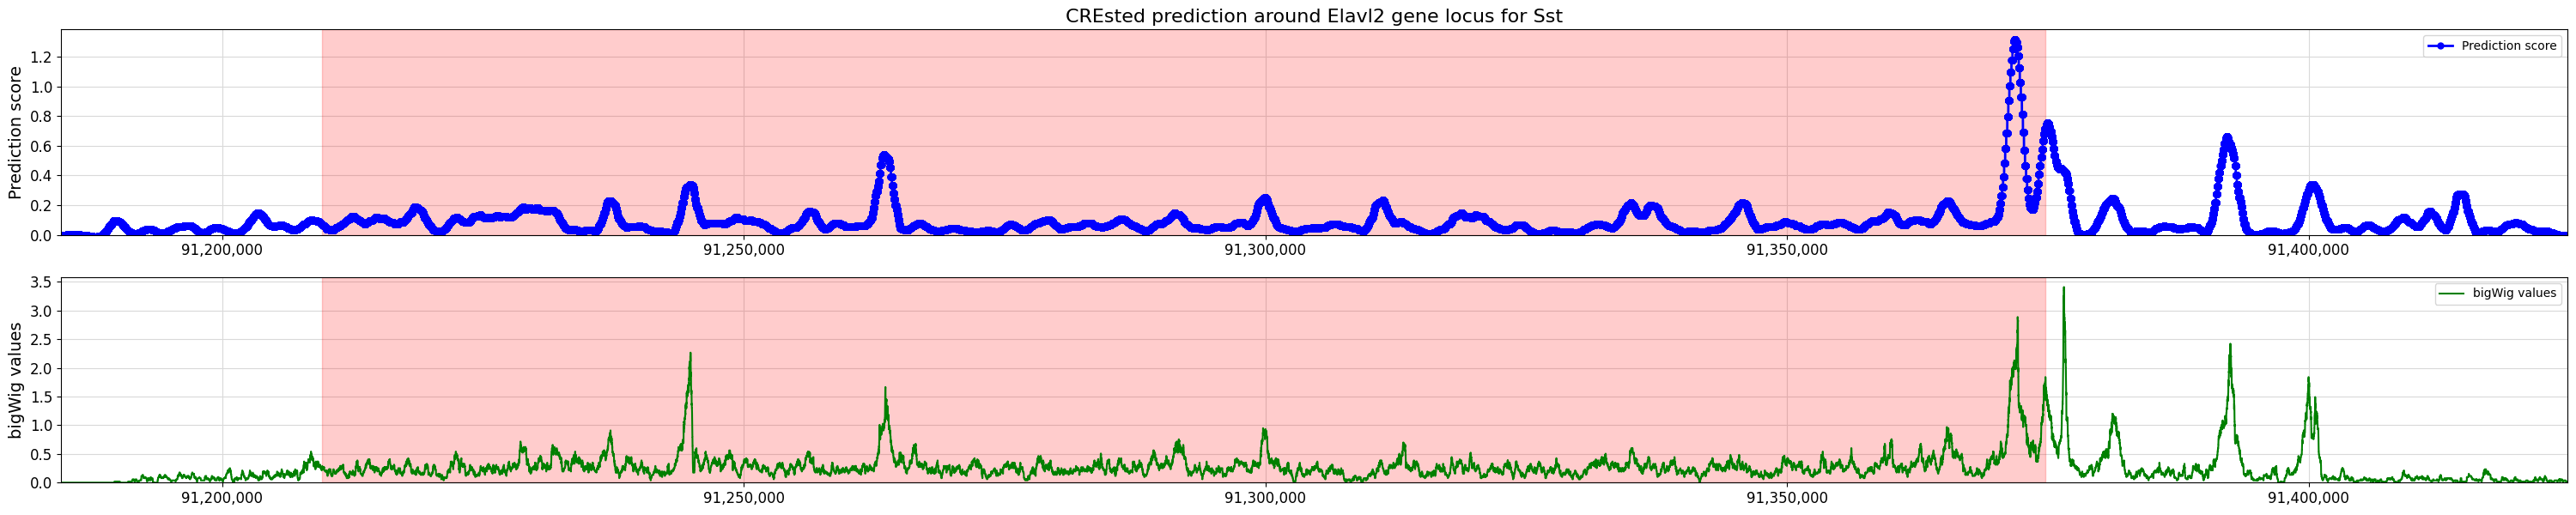

In [22]:
%matplotlib inline
crested.pl.locus.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    title="CREsted prediction around Elavl2 gene locus for Sst",
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
)

### With DeepMouseBrain3

In [23]:
scores, coordinates, min_loc, max_loc, tss_position = crested.tl.score_gene_locus(
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    target_idx=class_idx,
    model=model_dmb3,
    strand=strand,
    upstream=upstream,
    downstream=downstream,
    step_size=100,
)

I0000 00:00:1771250088.210674 2305125 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 184 bytes spill stores, 184 bytes spill loads

I0000 00:00:1771250088.387389 2305123 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 344 bytes spill stores, 340 bytes spill loads

I0000 00:00:1771250088.440190 2305127 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1771250088.641453 2305125 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1771250088.711521 2305119 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 12 bytes spill stores, 12 bytes spill loads



18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

I0000 00:00:1771250100.859848 2305173 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1771250100.907277 2305174 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1771250101.024306 2305175 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 152 bytes spill stores, 80 bytes spill loads

I0000 00:00:1771250101.030524 2305178 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 208 bytes spill stores, 208 bytes spill loads

I0000 00:00:1771250101.210020 2305177 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_369', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1771250101.314247 2305

19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 484ms/step


2026-02-16T14:55:08.018731+0100 WARNING Argument `title` only applying to the top plot is deprecated since version 2.0.0 to make behavior consistent. To keep a primary title, please use `suptitle='CREsted prediction around Elavl2 gene locus for Sst'` or `title=['CREsted prediction around Elavl2 gene locus for Sst', '']`.


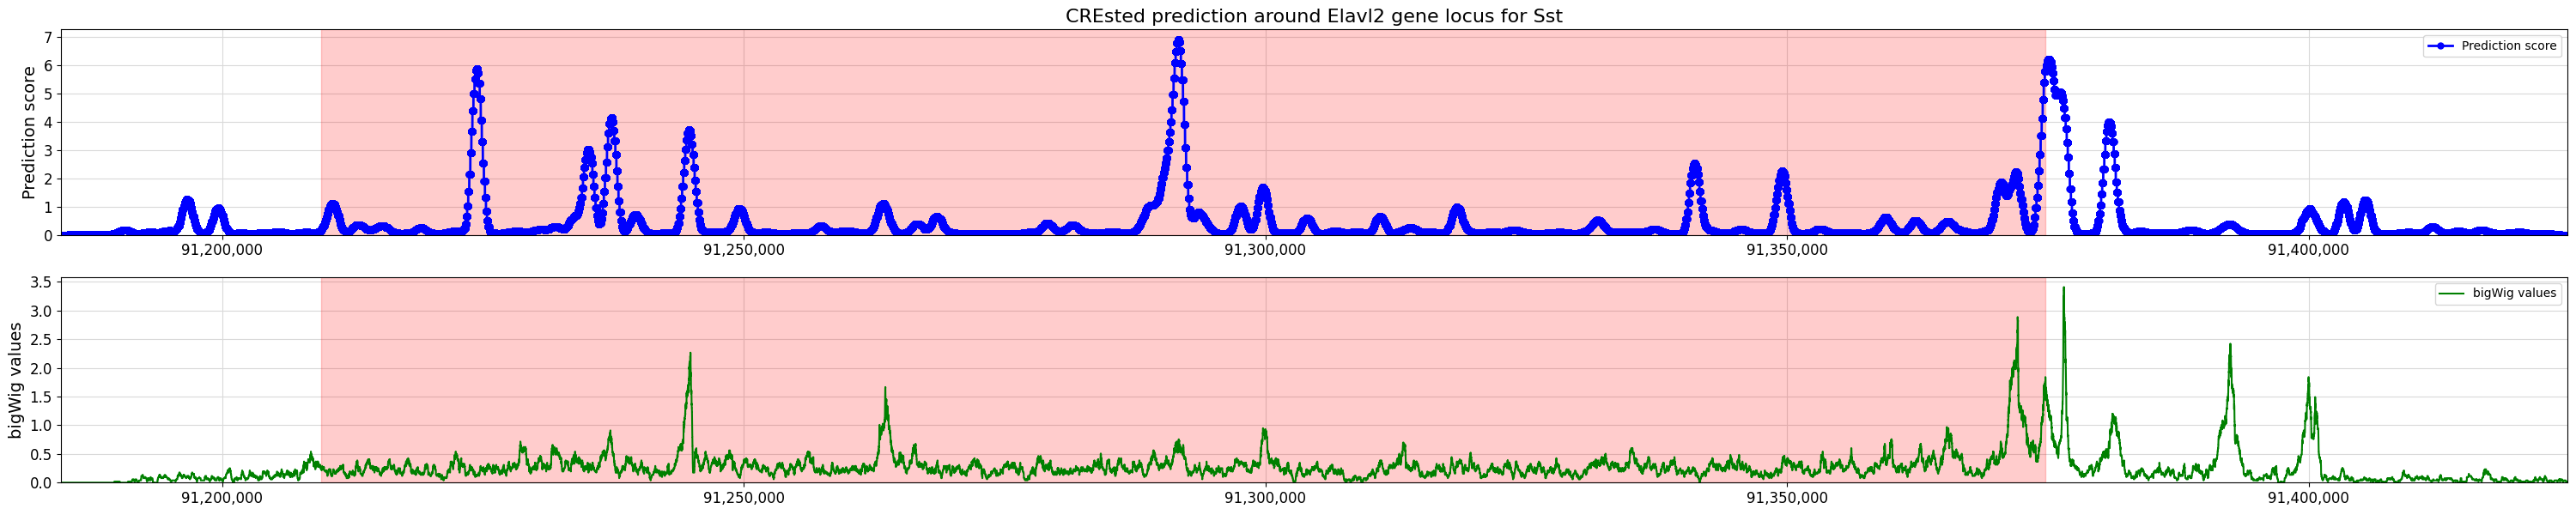

In [24]:
%matplotlib inline
crested.pl.locus.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    title="CREsted prediction around Elavl2 gene locus for Sst",
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
)